## 1. Loading the blood donations data and performing Data Preprocessing
<p>We now know that we are working with a typical CSV file (i.e., the delimiter is <code>,</code>, etc.). We proceed to loading the data into memory.</p>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
transfusion = pd.read_csv(r"C:\Users\syedk\OneDrive\Desktop\Slash Mark IT Startup\Give-Life-Predict-Blood-Donations-master\Give-Life-Predict-Blood-Donations-master\Datasets\transfusion.data")

# Display the first few rows
print(transfusion.head())

# Check for missing values
print(transfusion.isnull().sum())

# Summary statistics
print(transfusion.describe())


   Recency (months)  Frequency (times)  Monetary (c.c. blood)  Time (months)  \
0                 2                 50                  12500             98   
1                 0                 13                   3250             28   
2                 1                 16                   4000             35   
3                 2                 20                   5000             45   
4                 1                 24                   6000             77   

   whether he/she donated blood in March 2007  
0                                           1  
1                                           1  
2                                           1  
3                                           1  
4                                           0  
Recency (months)                              0
Frequency (times)                             0
Monetary (c.c. blood)                         0
Time (months)                                 0
whether he/she donated blood in March 2

## 2. Inspecting transfusion DataFrame
<p>Let's briefly return to our discussion of RFM model. RFM stands for Recency, Frequency and Monetary Value and it is commonly used in marketing for identifying your best customers. In our case, our customers are blood donors.</p>
<p>RFMTC is a variation of the RFM model. Below is a description of what each column means in our dataset:</p>
<ul>
<li>R (Recency - months since the last donation)</li>
<li>F (Frequency - total number of donation)</li>
<li>M (Monetary - total blood donated in c.c.)</li>
<li>T (Time - months since the first donation)</li>
<li>a binary variable representing whether he/she donated blood in March 2007 (1 stands for donating blood; 0 stands for not donating blood)</li>
</ul>
<p>It looks like every column in our DataFrame has the numeric type, which is exactly what we want when building a machine learning model. Let's verify our hypothesis.</p>

In [2]:
# Print a concise summary of transfusion DataFrame
transfusion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            748 non-null    int64
 1   Frequency (times)                           748 non-null    int64
 2   Monetary (c.c. blood)                       748 non-null    int64
 3   Time (months)                               748 non-null    int64
 4   whether he/she donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


## 3. Creating target column
<p>We are aiming to predict the value in <code>whether he/she donated blood in March 2007</code> column. Let's rename this it to <code>target</code> so that it's more convenient to work with.</p>

   Recency (months)  Frequency (times)  Monetary (c.c. blood)  Time (months)  \
0         -0.927899           7.623346               7.623346       2.615633   
1         -1.175118           1.282738               1.282738      -0.257881   
2         -1.051508           1.796842               1.796842       0.029471   
3         -0.927899           2.482313               2.482313       0.439973   
4         -1.051508           3.167784               3.167784       1.753579   

   whether he/she donated blood in March 2007  
0                                           1  
1                                           1  
2                                           1  
3                                           1  
4                                           0  


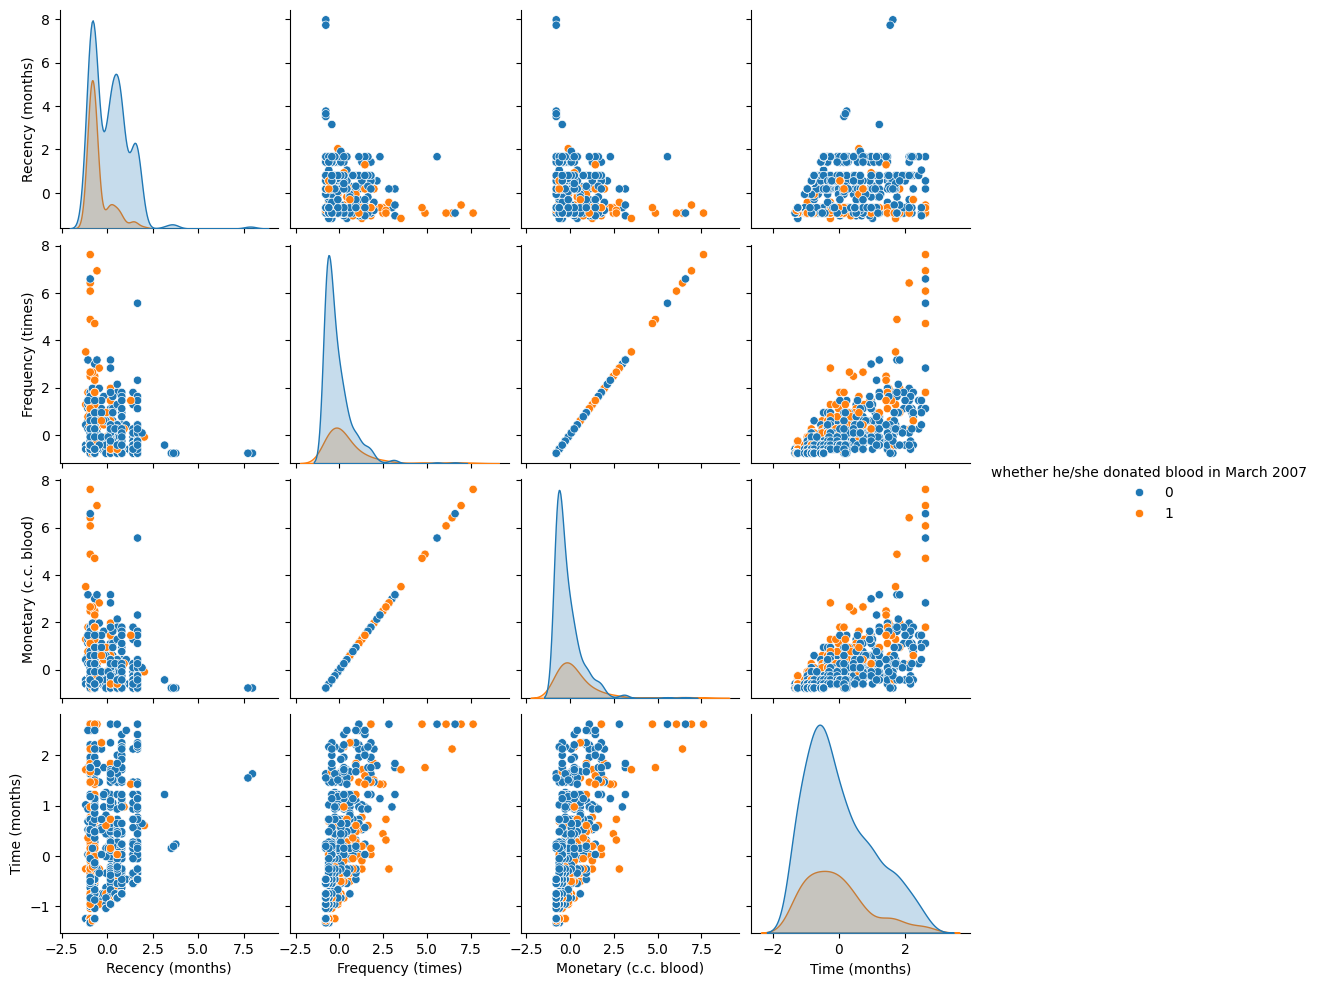

In [3]:
# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(transfusion.drop('whether he/she donated blood in March 2007', axis=1))

# Convert scaled features back to a DataFrame
transfusion_scaled = pd.DataFrame(scaled_features, columns=transfusion.columns[:-1])
transfusion_scaled['whether he/she donated blood in March 2007'] = transfusion['whether he/she donated blood in March 2007']

# Display the first few rows of the scaled dataset
print(transfusion_scaled.head())

# Visualize the distribution of the features
sns.pairplot(transfusion_scaled, hue='whether he/she donated blood in March 2007')
plt.show()


## Model Training and Hyperparameter Tuning
We'll use a few models and perform hyperparameter tuning using GridSearchCV.

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

# Split the data
X = transfusion_scaled.drop('whether he/she donated blood in March 2007', axis=1)
y = transfusion_scaled['whether he/she donated blood in March 2007']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models and hyperparameters
models = {
    'LogReg': LogisticRegression(),
    'Random_Forest': RandomForestClassifier(),
    'SVC': SVC(probability=True)
}

params = {
    'LogReg': {'C': [0.01, 0.1, 1, 10, 100]},
    'Random_Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    'SVC': {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
}

# Perform GridSearchCV
best_models = {}
for model_name in models:
    grid_search = GridSearchCV(models[model_name], params[model_name], cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_

# Evaluate models
for model_name in best_models:
    model = best_models[model_name]
    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    print(f'{model_name} AUC: {auc:.4f}')


LogReg AUC: 0.7534
Random_Forest AUC: 0.6764
SVC AUC: 0.7151


## Ensemble Methods
We'll combine predictions from multiple models to create an ensemble.

In [5]:
from sklearn.ensemble import VotingClassifier

# Create an ensemble model using the best models
ensemble = VotingClassifier(estimators=[
    ('LogReg', best_models['LogReg']),
    ('Random_Forest', best_models['Random_Forest']),
    ('SVC', best_models['SVC'])
], voting='soft')

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict_proba(X_test)[:, 1]
ensemble_auc = roc_auc_score(y_test, y_pred_ensemble)

print(f'Ensemble AUC: {ensemble_auc:.4f}')


Ensemble AUC: 0.7075


##  Visualization
We'll add visualizations to compare model performance.


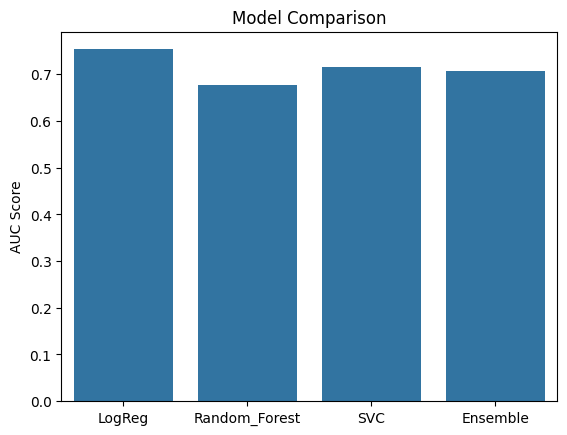

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot AUC scores
model_names = list(best_models.keys()) + ['Ensemble']
auc_scores = [roc_auc_score(y_test, best_models[model].predict_proba(X_test)[:, 1]) for model in best_models] + [ensemble_auc]

sns.barplot(x=model_names, y=auc_scores)
plt.ylabel('AUC Score')
plt.title('Model Comparison')
plt.show()


## Documentation and Code Structure
We'll organize the code into functions and add comments for clarity.

logreg AUC: 0.7534
random_forest AUC: 0.6652
svc AUC: 0.7151
Ensemble AUC: 0.6979


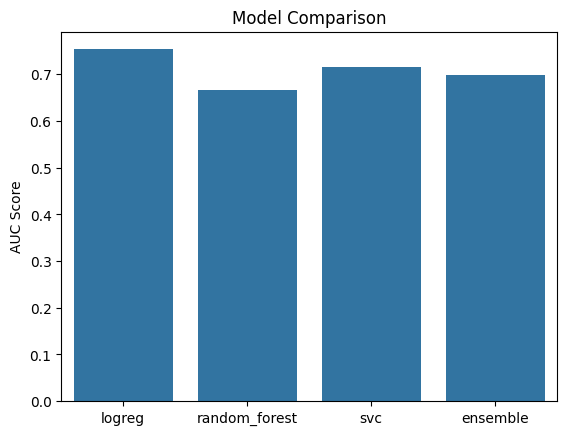

In [8]:
# Function to preprocess data
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df.drop('whether he/she donated blood in March 2007', axis=1))
    df_scaled = pd.DataFrame(scaled_features, columns=df.columns[:-1])
    df_scaled['whether he/she donated blood in March 2007'] = df['whether he/she donated blood in March 2007']
    return df_scaled

# Function to perform model training and hyperparameter tuning
def train_and_tune_models(X_train, y_train, models, params):
    best_models = {}
    for model_name in models:
        grid_search = GridSearchCV(models[model_name], params[model_name], cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
    return best_models

# Function to evaluate models
def evaluate_models(models, X_test, y_test):
    auc_scores = {}
    for model_name in models:
        model = models[model_name]
        y_pred = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        auc_scores[model_name] = auc
    return auc_scores

# Function to create and evaluate ensemble model
def create_ensemble_model(best_models, X_train, y_train, X_test, y_test):
    ensemble = VotingClassifier(estimators=[(name, model) for name, model in best_models.items()], voting='soft')
    ensemble.fit(X_train, y_train)
    y_pred_ensemble = ensemble.predict_proba(X_test)[:, 1]
    ensemble_auc = roc_auc_score(y_test, y_pred_ensemble)
    return ensemble_auc

# Main function to run the complete workflow
def main():
    file_path = r"C:\Users\syedk\OneDrive\Desktop\Slash Mark IT Startup\Give-Life-Predict-Blood-Donations-master\Give-Life-Predict-Blood-Donations-master\Datasets\transfusion.data"
    df_scaled = preprocess_data(file_path)
    
    X = df_scaled.drop('whether he/she donated blood in March 2007', axis=1)
    y = df_scaled['whether he/she donated blood in March 2007']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {
        'logreg': LogisticRegression(),
        'random_forest': RandomForestClassifier(),
        'svc': SVC(probability=True)
    }
    
    params = {
        'logreg': {'C': [0.01, 0.1, 1, 10, 100]},
        'random_forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
        'svc': {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
    }
    
    best_models = train_and_tune_models(X_train, y_train, models, params)
    auc_scores = evaluate_models(best_models, X_test, y_test)
    
    for model_name, auc in auc_scores.items():
        print(f'{model_name} AUC: {auc:.4f}')
    
    ensemble_auc = create_ensemble_model(best_models, X_train, y_train, X_test, y_test)
    print(f'Ensemble AUC: {ensemble_auc:.4f}')
    
    # Visualize model comparison
    model_names = list(auc_scores.keys()) + ['ensemble']
    auc_scores_list = list(auc_scores.values()) + [ensemble_auc]
    
    sns.barplot(x=model_names, y=auc_scores_list)
    plt.ylabel('AUC Score')
    plt.title('Model Comparison')
    plt.show()

# Run the main function
main()
